In [ ]:
#importing all the neccesary libraries
import numpy as np
import matplotlib.pyplot as plt
import random

**Faster Matrix Multiplication**

The idea behind this paper is to use sampling methods as opposed to the traditional linear methods for sampling like count sketch or J-L lemma which dont need to look at the data to reduce the dimensions of the original matrix or to just make the matrix multiplication faster

The given below code implements the coordinated sampling method shown in the paper by christopher musco

**Coordinated Sampling**
#### **Input:**
- Matrix \( A \) of size \( n \times d \).
- Random seeds.
- Number of row samples, \( k \).

#### **Output:**
- Sketch \( S(A) = \{ I_A, V_A, \ta \} \), where:
  - \( I_A \) is a subset of row indices from \( \{1, ..., n\} \).
  - \( V_A \) contains \( A_i \) for all \( i \in I_A \).

#### **Steps:**
1. Use random seeds to select a uniformly random hash function:
   $$
   h: \{1, ..., n\} \to [0,1]
   $$
2. Initialize \( I_A \) and \( V_A \) as empty lists.
3. Compute rank for each row \( A_i \) (if \( A_i !=0 \)):
   $$
   R_i = \frac{h(i)}{\|A_i\|_2^2}
   $$
4. Set:
   - ta=equal to the \((k+1)\)st smallest value of \( R_i \), or
   - \( ta = infinty \) if \( A \) has fewer than \( k+1 \) nonzero rows.
5. For each \( i \) where \( A_i \neq 0 \):
   - If \( R_i < \tau_A \):
     - Append \( i \) to \( I_A \).
     - Append \( A_i \) to \( V_A \).
6. Return:
   $$
   S(A) = \{ I_A, V_A, ta\}
   $$



In [ ]:
hash = np.random.uniform(0, 1, size=10000)

In [ ]:
def coordinated_sampling(A, k):
    # here k are the number of parameters
    # A is the original matrix of size n x d
    n, d = np.shape(A)
    #setting the shared random seed
    random.seed(42)

    # hash function which assigns the values between 0 and 1 randomly to the n numbers
    hash_function = hash

    # i_a to store the indexes and va to store the values
    i_a = []
    v_a = []

    # Calculating ri
    r = np.zeros(n)
    for i in range(n):
        norm = np.linalg.norm(A[i])
        if norm != 0:
            r[i] = hash[i] / (norm ** 2)
        else:
            r[i] = np.inf

    # Get the (k+1)-th smallest rank as the threshold
    r_sorted = np.sort(r)
    threshold = r_sorted[k] if k < n else np.inf

    # Sample rows based on the threshold
    for i in range(n):
        if r[i] < threshold:
            i_a.append(i)
            v_a.append(A[i])

    # the sketch matrix
    sketch = {
        'IA': np.array(i_a),
        'VA': np.array(v_a),
        'ta': threshold
    }
    return sketch

In [ ]:
#creating the matrix a
A=np.random.randn(10000,10000)
sketch_a=coordinated_sampling(A,25)

In [ ]:
#creating the matrix b
B=np.random.randn(10000,10000)
sketch_b=coordinated_sampling(B,25)

Now that we are done with sampling and creating sketches of the original matrices, we will use this to create a matrix product approximate and see the mean variance and the norm error for the same

In [ ]:
sketch_b['VA']

array([[-0.74124129, -0.2969846 ,  0.95876894, ...,  1.45865647,
        -0.23324412, -0.52141743],
       [-1.13702933,  0.08894364, -0.54999653, ...,  0.72553214,
         0.32400155,  0.21287766],
       [-0.39623362,  1.43277443, -1.02396555, ..., -1.36930824,
        -0.84502592, -0.45553491],
       ...,
       [ 0.53750993,  1.51234701, -1.20709982, ...,  0.6301921 ,
         0.57489648, -0.11011516],
       [ 0.06656158,  0.17358176,  2.18066087, ..., -0.85164328,
         0.06270524,  1.6769187 ],
       [ 0.73037967, -1.30334992,  0.52295925, ...,  0.47014217,
         0.1106836 ,  0.70754781]])

**Approximate matrix multiplication**

After generation of sketches from A and B, we will take the outerproduct of the common indices and then generate an approximate form of the original matrix

In [ ]:
def approximate_matrix_multiplication(sketch_A, sketch_B):
    # fnding common indieces between both the matrices
    common_indices = np.intersect1d(sketch_A['IA'], sketch_B['IA'])

    #w=da*d_b
    d_A = sketch_A['VA'].shape[1]
    d_B = sketch_B['VA'].shape[1]
    W = np.zeros((d_A, d_B))

    for i in common_indices:
#getting the common values
        idx_A = np.where(sketch_A['IA'] == i)[0][0]
        idx_B = np.where(sketch_B['IA'] == i)[0][0]

        Ai = sketch_A['VA'][idx_A]
        Bi = sketch_B['VA'][idx_B]
        norm_Ai = np.linalg.norm(Ai) ** 2
        norm_Bi = np.linalg.norm(Bi) ** 2
        denom = min(1, norm_Ai / sketch_A['ta'], norm_Bi / sketch_B['ta'])


        # outer product of the common rows
        W += np.outer(Ai, Bi.T) / denom

    return W

In [ ]:
W = approximate_matrix_multiplication(sketch_a, sketch_b)
w_norm=np.linalg.norm(W)

In [ ]:
sketch_a['VA'].shape

(25, 10000)

In [ ]:
sketch_b['VA'].shape

(25, 10000)

In [ ]:
W.shape

(10000, 10000)

In [ ]:
original_mul=A@B.T
norm_original=np.linalg.norm(original_mul)

In [ ]:
#getting the error from original vs approximate
error=norm_original-w_norm
print(error)

949896.0533618086


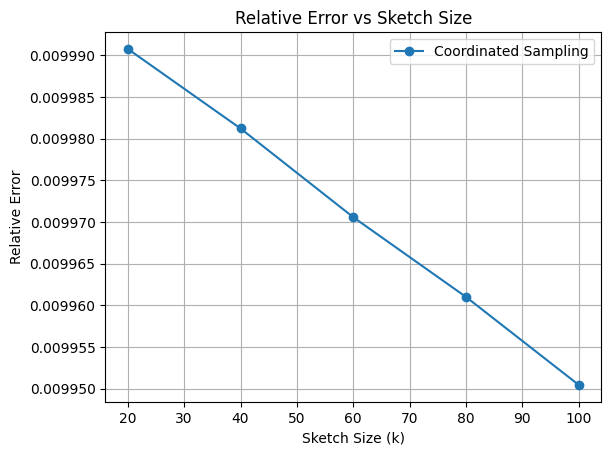

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection

# Compute the original matrix multiplication
ATB = np.dot(A.T, B)
norm_original = np.linalg.norm(A, 'fro') * np.linalg.norm(B, 'fro')

k_values = [20, 40, 60, 80, 100]
errors = []

for k in k_values:
    # Sketch matrices A and B
    sketch_A = coordinated_sampling(A, k)
    sketch_B = coordinated_sampling(B, k)

    # Compute the approximate multiplication using sketched matrices
    W = approximate_matrix_multiplication(sketch_A, sketch_B)

    # Compute the relative error wrt the original matrix
    error_iteration = np.linalg.norm(W - ATB, 'fro') / norm_original
    errors.append(error_iteration)

# Plot the error vs. sketch size
plt.plot(k_values, errors, marker='o', label='Coordinated Sampling')
plt.xlabel('Sketch Size (k)')
plt.ylabel('Relative Error')
plt.title('Relative Error vs Sketch Size')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#the jl-lemma
from sklearn.random_projection import GaussianRandomProjection

# Apply random projection to reduce dimensionality
transformer = GaussianRandomProjection(n_components=50)
A_reduced = transformer.fit_transform(A)
B_reduced = transformer.fit_transform(B)

# Approximate matrix multiplication
W_approx = np.dot(A_reduced, B_reduced.T)

In [ ]:
W_approx.shape

(10000, 10000)

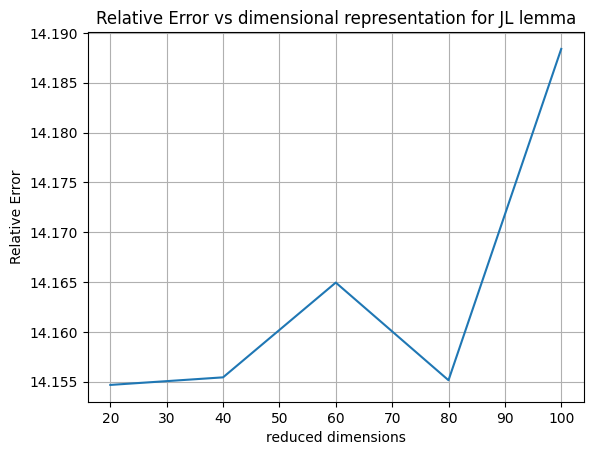

In [ ]:
norm_original = np.linalg.norm(ATB, 'fro')

n_components = [20, 40, 60, 80, 100]
error = []

for i in range(len(k_values)):
    transformer = GaussianRandomProjection(n_components=50)
    A_reduced = transformer.fit_transform(A)
    B_reduced = transformer.fit_transform(B)

# Approximate matrix multiplication
    W_approx = np.dot(A_reduced, B_reduced.T)
    error_iteration = np.linalg.norm(ATB - W_approx, 'fro') / norm_original
    error.append(error_iteration)
plt.plot(k_values, error)
plt.xlabel('reduced dimensions')
plt.ylabel('Relative Error')
plt.title('Relative Error vs dimensional representation for JL lemma')
plt.grid(True)
plt.show()


**Checking the performance of Coordianted sampling over sparse matrices**

In [ ]:
#code to get the sparse matrices in generated by CHATGPT
from scipy.sparse import coo_matrix

def generate_different_sparse_matrices(m, n, sparsity, outlier_ratio=0.1):
    """Generate two independent sparse matrices A and B with different sparsity patterns and values."""

    size = m * n
    num_nonzeros = int((1 - sparsity) * size)  # Number of nonzero elements

    # Generate independent values for A and B
    values_A = np.random.randn(num_nonzeros)  # Normal distribution
    values_B = np.random.uniform(-1, 1, num_nonzeros)  # Uniform distribution

    # Introduce outliers differently for A and B
    num_outliers = int(outlier_ratio * num_nonzeros)

    outlier_indices_A = np.random.choice(num_nonzeros, num_outliers, replace=False)
    outlier_indices_B = np.random.choice(num_nonzeros, num_outliers, replace=False)

    values_A[outlier_indices_A] *= 10  # Outliers in A
    values_B[outlier_indices_B] *= 5   # Outliers in B (different scaling)

    # Ensure independent sparsity patterns
    indices_A = np.random.choice(size, num_nonzeros, replace=False)
    indices_B = np.random.choice(size, num_nonzeros, replace=False)

    row_indices_A = indices_A // n
    col_indices_A = indices_A % n

    row_indices_B = indices_B // n
    col_indices_B = indices_B % n

    # Create two independent sparse matrices
    sparse_A = coo_matrix((values_A, (row_indices_A, col_indices_A)), shape=(m, n))
    sparse_B = coo_matrix((values_B, (row_indices_B, col_indices_B)), shape=(m, n))

    return sparse_A, sparse_B

# Example: Generate 1000x1000 sparse matrices with 10%, 40%, and 80% sparsity
m, n = 1000, 1000
sparse_10_a, sparse_10_b = generate_different_sparse_matrices(m, n, 0.10)
sparse_40_a, sparse_40_b = generate_different_sparse_matrices(m, n, 0.40)
sparse_80_a, sparse_80_b = generate_different_sparse_matrices(m, n, 0.80)

# Convert to dense format
dense_matrix_1 = sparse_10_a.toarray()
dense_matrix_2 = sparse_10_b.toarray()
dense_matrix_40_1 = sparse_40_a.toarray()
dense_matrix_40_2 = sparse_40_b.toarray()
dense_matrix_80_1 = sparse_80_a.toarray()
dense_matrix_80_2 = sparse_80_b.toarray()


Now that we have matrices which are 10% sparse, 40% sparse and 80% sparse. The next step is to compare the relative error between the approximate matrix multiplication for JL lemma and Coordinated sampling

<ipython-input-7-947b79a9f250>:23: RuntimeWarning: divide by zero encountered in divide
  W += np.outer(Ai, Bi.T) / denom
<ipython-input-7-947b79a9f250>:23: RuntimeWarning: invalid value encountered in divide
  W += np.outer(Ai, Bi.T) / denom
<ipython-input-7-947b79a9f250>:23: RuntimeWarning: invalid value encountered in add
  W += np.outer(Ai, Bi.T) / denom


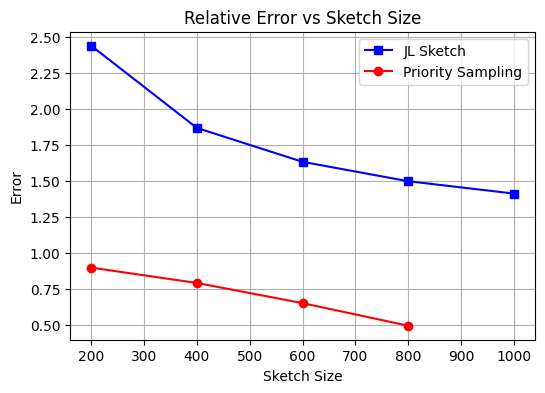

In [ ]:
#first plot
ATB = np.dot(dense_matrix_1.T, dense_matrix_2)
norm_original = np.linalg.norm(ATB, 'fro')

k = [200, 400, 600, 800, 1000]
error_jl = []
error_cs=[]

for i in range(len(k)):
    sketch_a = coordinated_sampling(dense_matrix_1, k[i])
    sketch_b = coordinated_sampling(dense_matrix_2, k[i])
    transformer = GaussianRandomProjection(n_components=k[i])
    A_reduced = transformer.fit_transform(dense_matrix_1)
    B_reduced = transformer.fit_transform(dense_matrix_2)

# Approximate matrix multiplication
    W_approx = np.dot(A_reduced, B_reduced.T)
    error_iteration_jl = np.linalg.norm(ATB - W_approx, 'fro') / norm_original
    error_jl.append(error_iteration_jl)
    W = approximate_matrix_multiplication(sketch_a, sketch_b)
    error_iteration_cs = np.linalg.norm(ATB - W, 'fro') / norm_original
    error_cs.append(error_iteration_cs)
plt.figure(figsize=(6, 4))
plt.plot(k, error_jl, marker='s', linestyle='-', label="JL Sketch", color="blue")
plt.plot(k, error_cs, marker='o', linestyle='-', label="Priority Sampling", color="red")

plt.xlabel("Sketch Size")
plt.ylabel("Error")
plt.title("Relative Error vs Sketch Size")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-7-947b79a9f250>:23: RuntimeWarning: divide by zero encountered in divide
  W += np.outer(Ai, Bi.T) / denom
<ipython-input-7-947b79a9f250>:23: RuntimeWarning: invalid value encountered in divide
  W += np.outer(Ai, Bi.T) / denom
<ipython-input-7-947b79a9f250>:23: RuntimeWarning: invalid value encountered in add
  W += np.outer(Ai, Bi.T) / denom


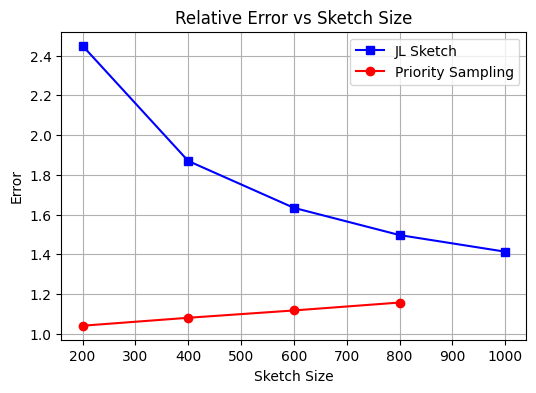

In [ ]:
#first plot
ATB = np.dot(dense_matrix_1.T, dense_matrix_2)
norm_original = np.linalg.norm(ATB, 'fro')

k = [200, 400, 600, 800, 1000]
error_jl = []
error_cs=[]

for i in range(len(k)):
    sketch_a = coordinated_sampling(dense_matrix_40_1, k[i])
    sketch_b = coordinated_sampling(dense_matrix_40_2, k[i])
    transformer = GaussianRandomProjection(n_components=k[i])
    A_reduced = transformer.fit_transform(dense_matrix_1)
    B_reduced = transformer.fit_transform(dense_matrix_2)

# Approximate matrix multiplication
    W_approx = np.dot(A_reduced, B_reduced.T)
    error_iteration_jl = np.linalg.norm(ATB - W_approx, 'fro') / norm_original
    error_jl.append(error_iteration_jl)
    W = approximate_matrix_multiplication(sketch_a, sketch_b)
    error_iteration_cs = np.linalg.norm(ATB - W, 'fro') / norm_original
    error_cs.append(error_iteration_cs)
plt.figure(figsize=(6, 4))
plt.plot(k, error_jl, marker='s', linestyle='-', label="JL Sketch", color="blue")
plt.plot(k, error_cs, marker='o', linestyle='-', label="Priority Sampling", color="red")

plt.xlabel("Sketch Size")
plt.ylabel("Error")
plt.title("Relative Error vs Sketch Size")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-7-947b79a9f250>:23: RuntimeWarning: divide by zero encountered in divide
  W += np.outer(Ai, Bi.T) / denom
<ipython-input-7-947b79a9f250>:23: RuntimeWarning: invalid value encountered in divide
  W += np.outer(Ai, Bi.T) / denom
<ipython-input-7-947b79a9f250>:23: RuntimeWarning: invalid value encountered in add
  W += np.outer(Ai, Bi.T) / denom


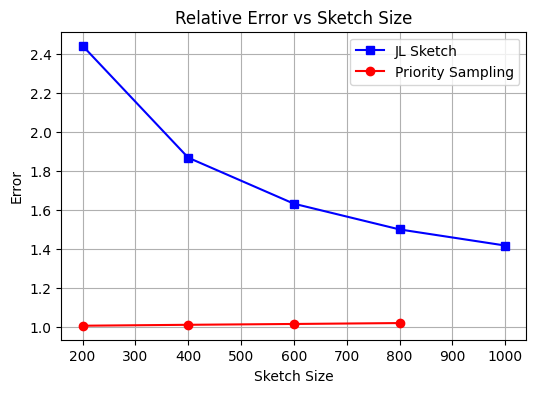

In [ ]:
#first plot
ATB = np.dot(dense_matrix_1.T, dense_matrix_2)
norm_original = np.linalg.norm(ATB, 'fro')

k = [200, 400, 600, 800, 1000]
error_jl = []
error_cs=[]

for i in range(len(k)):
    sketch_a = coordinated_sampling(dense_matrix_80_1, k[i])
    sketch_b = coordinated_sampling(dense_matrix_80_2, k[i])
    transformer = GaussianRandomProjection(n_components=k[i])
    A_reduced = transformer.fit_transform(dense_matrix_1)
    B_reduced = transformer.fit_transform(dense_matrix_2)

# Approximate matrix multiplication
    W_approx = np.dot(A_reduced, B_reduced.T)
    error_iteration_jl = np.linalg.norm(ATB - W_approx, 'fro') / norm_original
    error_jl.append(error_iteration_jl)
    W = approximate_matrix_multiplication(sketch_a, sketch_b)
    error_iteration_cs = np.linalg.norm(ATB - W, 'fro') / norm_original
    error_cs.append(error_iteration_cs)
plt.figure(figsize=(6, 4))
plt.plot(k, error_jl, marker='s', linestyle='-', label="JL Sketch", color="blue")
plt.plot(k, error_cs, marker='o', linestyle='-', label="Priority Sampling", color="red")

plt.xlabel("Sketch Size")
plt.ylabel("Error")
plt.title("Relative Error vs Sketch Size")
plt.legend()
plt.grid(True)
plt.show()

**Sketching Regression**

Using coordinate sampling described in the paper to the regression problem

Coordinated sampling algortihm using leverage scores for the matrix A and b where they represent the standard sentiment forms

In [ ]:
def sketch_regression(A,b,seed,error):
  n,d=A.shape
  #fixes the indexing issues
  sample_size=(int(d/error)-1)
  random.seed(seed)
  h=np.random.uniform(0, 1, size=n)
  mul=np.linalg.inv(A.T@A)
  l=[]
  i_a=[]
  v_a=[]
  r=np.empty(n)
  for i in range(max(n,d)):
    l_i=A[i]@mul@A[i].T
    l.append(l_i)
    r_i=h[i]/l[i]
    r[i]=r_i
  r_sorted=np.sort(r)
  threshold=r_sorted[sample_size]
  for i in range(n):
        if r[i] < threshold:
            i_a.append(i)
            v_a.append(A[i])
  sketch_A = {
        'IA': np.array(i_a),
        'VA': np.array(v_a),
        'ta': threshold
    }

  sketch_b=coordinated_sampling(b.reshape(-1,1),sample_size)
  return sketch_A,sketch_b, mul




In [ ]:
def approximate_regression(sketch_A, sketch_b,mul):
  common_indices = np.intersect1d(sketch_A['IA'], sketch_b['IA'])
  d_A = sketch_A['VA'].shape[1]
  d_B = sketch_b['VA'].shape[1]
  W = np.zeros((d_A, d_B))
  for i in common_indices:
#getting the common values
   idx_A = np.where(sketch_A['IA'] == i)[0][0]
   idx_B = np.where(sketch_b['IA'] == i)[0][0]
#finding the common eleme ts
   Ai = sketch_A['VA'][idx_A]
   Bi = sketch_b['VA'][idx_B]
   leverage_score=Ai@mul@Ai.T
   norm_Bi = np.linalg.norm(Bi) ** 2
   denom = min(1, leverage_score / sketch_A['ta'], norm_Bi / sketch_b['ta'])
#getting the weight matrix
   W += np.outer(Ai, Bi) / denom
   #getting the approximated values
   x = mul @ W
  return x

Testing this on two random matrices A and B created synthetically using chatGPT

In [ ]:
import numpy as np

# Set dimensions
n, d = 100, 10  # 100 samples, 10 features

# Generate random A matrix with values from a normal distribution
A = np.random.randn(n, d)

# Generate a random coefficient vector
true_x = np.random.randn(d)

# Generate b with some noise
b = A @ true_x + np.random.randn(n) * 0.1  # Adding small noise

# Print dimensions for verification
print("A shape:", A.shape)
print("b shape:", b.shape)


A shape: (100, 10)
b shape: (100,)


In [ ]:
sketch_a,sketch_b,mul=sketch_regression(A,b,42,0.1)

In [ ]:
print(sketch_a['VA'].shape)
print(sketch_b['VA'].shape)

(99, 10)
(99, 1)


In [ ]:
x_star=approximate_regression(sketch_a,sketch_b,mul)

In [ ]:
b_pred=A@x_star

In [ ]:
print(b.shape)

(100,)


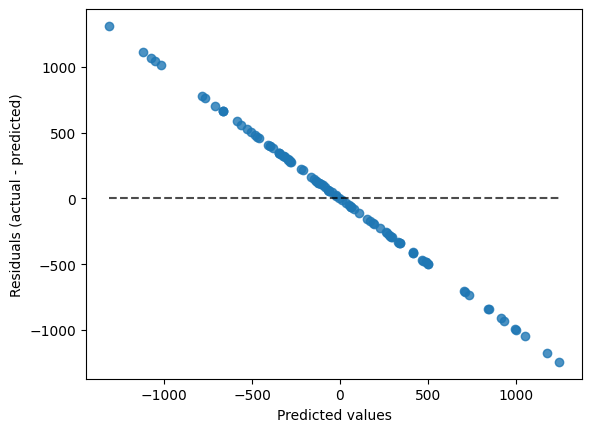

In [ ]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=b.reshape(-1,1), y_pred=b_pred)
display.plot()
plt.show()

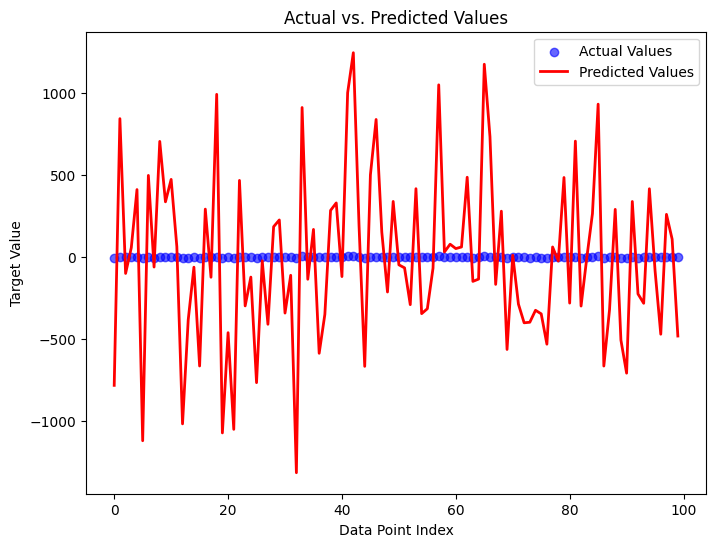

In [ ]:
import matplotlib.pyplot as plt

def plot_regression_fit(b, b_pred):
    plt.figure(figsize=(8, 6))

    # Scatter plot of actual values
    plt.scatter(range(len(b)), b, color='blue', label='Actual Values', alpha=0.6)

    # Line plot of predicted values
    plt.plot(range(len(b_pred)), b_pred, color='red', label='Predicted Values', linewidth=2)

    plt.xlabel("Data Point Index")
    plt.ylabel("Target Value")
    plt.title("Actual vs. Predicted Values")
    plt.legend()
    plt.show()

plot_regression_fit(b, b_pred)


**Using the IMDB dataset to check for anomlaies**

In [ ]:
#loading the data
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print(os.listdir(path))


['IMDB Dataset.csv']


In [ ]:
import pandas as pd
csv_file_path = os.path.join(path, "IMDB Dataset.csv")
df = pd.read_csv(csv_file_path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
x=df['review']
y=df['sentiment']

In [ ]:
y.nunique()

2

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=512)
X_tfidf = vectorizer.fit_transform(x)


In [ ]:
x_array=X_tfidf.toarray()
print(x_array)

[[0.         0.         0.04067688 ... 0.10401927 0.         0.05974542]
 [0.         0.         0.05522325 ... 0.04707246 0.         0.        ]
 [0.         0.         0.         ... 0.         0.11332922 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.11424457 ... 0.0486912  0.         0.        ]
 [0.         0.         0.06458825 ... 0.05505522 0.         0.        ]]


In [ ]:
y = y.map({'positive': 1, 'negative': 0})  # Convert to binary (0,1)

In [ ]:
y=np.array(y)

In [ ]:
print(x_array.shape)

(50000, 512)


In [ ]:
hash = np.random.uniform(0, 1, size=50000)

In [ ]:
sketch_a,sketch_b,mul=sketch_regression(x_array,y,42,0.1)

In [ ]:
x_star=approximate_regression(sketch_a,sketch_b,mul)

In [ ]:
y_pred=x_array@x_star

In [ ]:
y_pred_prob = 1 / (1 + np.exp(-(y_pred)))
y_pred = (y_pred_prob > 0.5).astype(int)


In [ ]:
y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

The code below is generated by CHATGPT

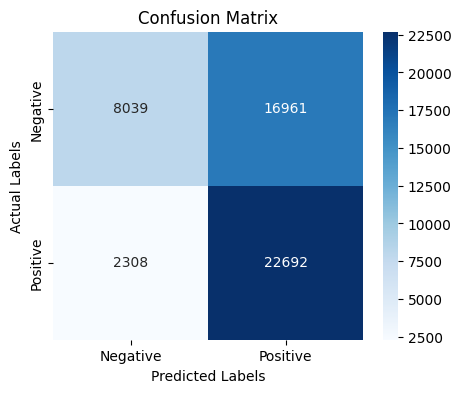

              precision    recall  f1-score   support

           0       0.78      0.32      0.45     25000
           1       0.57      0.91      0.70     25000

    accuracy                           0.61     50000
   macro avg       0.67      0.61      0.58     50000
weighted avg       0.67      0.61      0.58     50000



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y, y_pred)

# Step 3: Visualize Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

# Step 4: Print Classification Report (Accuracy, Precision, Recall, F1)
print(classification_report(y, y_pred))


In [ ]:
upper=abs(y_pred-y)
lower=np.linalg.norm(y)
final_error=upper/lower
plt.plot(x=y, y=final_error)